*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.6.3
IPython 6.2.1

tensorflow 1.5.0-rc1


# -

A convolutional autoencoder using nearest neighbor upscaling layers that compresses 768-pixel MNIST images down to a 7x7x4 (196 pixel) representation.

In [2]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import numpy as np


##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.001
num_epochs = 5
batch_size = 128

# Architecture
num_features = 784
num_hidden_1 = 32

# Other
random_seed = 123


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [3]:
##########################
### MODEL
##########################

def same_padding(kernel_width, stride):
    return (kernel_width - stride) // 2

class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(ConvolutionalAutoencoder, self).__init__()
        
        ### ENCODER
        
        # 28x28x1 => 28x28x8
        self.conv_1 = torch.nn.Conv2d(in_channels=1,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=same_padding(3, 1))
        # 28x28x8 => 14x14x8                              
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=same_padding(2, 2))                                       
        # 14x14x8 => 14x14x16
        self.conv_2 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=same_padding(3, 1))                 
        # 14x14x16 => 7x7x16                             
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2),
                                         stride=(2, 2),
                                         padding=same_padding(2, 1))
        
        ### DECODER
                                         
        # 7x7x16 => 14x14x16                            
        self.unpool_1 = torch.nn.Upsample(scale_factor=2,
                                          mode='nearest')
        # 14x14x16 => 14x14x8
        self.conv_3 = torch.nn.Conv2d(in_channels=16,
                                      out_channels=8,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=same_padding(3, 1))
        # 14x14x8 => 28x28x8                            
        self.unpool_2 = torch.nn.Upsample(scale_factor=2,
                                          mode='nearest')
        # 28x28x8 => 28x28x1
        self.conv_4 = torch.nn.Conv2d(in_channels=8,
                                      out_channels=1,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=same_padding(3, 1))
        
    def forward(self, x):
        
        ### ENCODER
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        
        ### DECODER
        x = self.unpool_1(x)
        x = self.conv_3(x)
        x = self.unpool_2(x)
        x = self.conv_4(x)
        x = F.sigmoid(x)
        return x

    
torch.manual_seed(0)
model = ConvolutionalAutoencoder(num_features=num_features)

if torch.cuda.is_available():
    model.cuda()
    

##########################
### COST AND OPTIMIZER
##########################

cost_fn = torch.nn.BCELoss() # torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [4]:
from torch.autograd import Variable
   

for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        # don't need labels, only the images (features)
        features = Variable(features)

        if torch.cuda.is_available():
            features, targets = features.cuda(), targets.cuda()
            
        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = cost_fn(decoded, features)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_dataset)//batch_size, cost.data[0]))

Epoch: 001/005 | Batch 000/468 | Cost: 0.6532
Epoch: 001/005 | Batch 050/468 | Cost: 0.2281
Epoch: 001/005 | Batch 100/468 | Cost: 0.1708
Epoch: 001/005 | Batch 150/468 | Cost: 0.1332
Epoch: 001/005 | Batch 200/468 | Cost: 0.1125
Epoch: 001/005 | Batch 250/468 | Cost: 0.1081
Epoch: 001/005 | Batch 300/468 | Cost: 0.1026
Epoch: 001/005 | Batch 350/468 | Cost: 0.1002
Epoch: 001/005 | Batch 400/468 | Cost: 0.0963
Epoch: 001/005 | Batch 450/468 | Cost: 0.0954
Epoch: 002/005 | Batch 000/468 | Cost: 0.0910
Epoch: 002/005 | Batch 050/468 | Cost: 0.0894
Epoch: 002/005 | Batch 100/468 | Cost: 0.0904
Epoch: 002/005 | Batch 150/468 | Cost: 0.0868
Epoch: 002/005 | Batch 200/468 | Cost: 0.0907
Epoch: 002/005 | Batch 250/468 | Cost: 0.0878
Epoch: 002/005 | Batch 300/468 | Cost: 0.0886
Epoch: 002/005 | Batch 350/468 | Cost: 0.0854
Epoch: 002/005 | Batch 400/468 | Cost: 0.0857
Epoch: 002/005 | Batch 450/468 | Cost: 0.0849
Epoch: 003/005 | Batch 000/468 | Cost: 0.0861
Epoch: 003/005 | Batch 050/468 | C

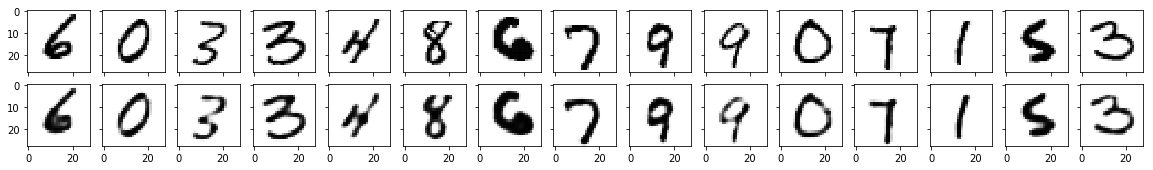

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features.data.numpy()[:n_images]
decoded_images = decoded.data.numpy()[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        ax[i].imshow(img[i].reshape((image_width, image_width)), cmap='binary')